# 深度概率编程CVAE

## 概述

本例采用MindSpore的深度概率编程方法应用于条件变分自编码器(CVAE)模型训练。  
整体流程如下：

1. 数据集准备
2. 定义条件变分自编码器网络；
3. 定义损失函数和优化器；
4. 训练生成模型。
5. 生成新样本或重构输入样本。

> 本例适用于GPU和Ascend环境。

## 数据准备

### 下载数据集

本例使用MNIST_Data数据集，执行如下命令进行下载并解压到对应位置：

In [1]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip
!unzip -o MNIST_Data.zip -d ./datasets
!tree ./datasets/MNIST_Data/

--2020-12-18 10:55:35--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10754903 (10M) [application/zip]
Saving to: ‘MNIST_Data.zip’

MNIST_Data.zip      100%[===================>]  10.26M  49.3MB/s    in 0.2s    

2020-12-18 10:55:35 (49.3 MB/s) - ‘MNIST_Data.zip’ saved [10754903/10754903]

Archive:  MNIST_Data.zip
   creating: ./datasets/MNIST_Data/test/
  inflating: ./datasets/MNIST_Data/test/t10k-images-idx3-ubyte  
  inflating: ./datasets/MNIST_Data/test/t10k-labels-idx1-ubyte  
   creating: ./datasets/MNIST_Data/train/
  inflating: ./datasets/MNIST_Data/train/train-images-idx3-ubyte  
  inflating: ./datasets/MNIST_Data/train/train-labels-idx1-ubyte  

### 数据增强

将数据集增强为适应CVAE网络训练要求的数据，本例主要是将原始图片像素大小由$28\times28$增强为$32\times32$，同时将多张图片组成1个`batch`来加速训练。

In [2]:
import mindspore.common.dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """
    create dataset for train or test
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0

    # define map operations
    resize_op = CV.Resize((resize_height, resize_width))  # Bilinear mode
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()

    # apply map operations on images
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # apply DatasetOps
    mnist_ds = mnist_ds.batch(batch_size)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

## 定义条件变分自编码器网络

变分自编码器的构成主要分为三个部分，编码器，解码器和隐空间。  
其中：  
编码器（Encoder）主要作用是将训练数据进行降维，压缩，提取特征，形成特征向量，存储在隐空间中。  
解码器（Decoder）主要作用是将训练数据因空间分布的参数进行解码，还原生成出新的图像。  
隐空间主要作用是将模型的特征按照某种分布特性进行存储，属于编码器和解码器中间的桥梁。  
本例中条件变分自编码器（CVAE）是在变分自编码器的基础上增添标签训练，在后续随机采样生成图片的过程中，可以施加标签指定生成该条件的图片。

In [3]:
import os
import mindspore.nn as nn
from mindspore import context, Tensor
import mindspore.ops as ops

context.set_context(mode=context.GRAPH_MODE,device_target="GPU")
IMAGE_SHAPE=(-1,1,32,32)
image_path = os.path.join("./datasets/MNIST_Data","train")

class Encoder(nn.Cell):
    def __init__(self, num_classes):
        super(Encoder, self).__init__()
        self.fc1 = nn.Dense(1024 + num_classes, 400)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.concat = ops.Concat(axis=1)
        self.one_hot = nn.OneHot(depth=num_classes)

    def construct(self, x, y):
        x = self.flatten(x)
        y = self.one_hot(y)
        input_x = self.concat((x, y))
        input_x = self.fc1(input_x)
        input_x = self.relu(input_x)
        return input_x

class Decoder(nn.Cell):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc2 = nn.Dense(400, 1024)
        self.sigmoid = nn.Sigmoid()
        self.reshape = ops.Reshape()

    def construct(self, z):
        z = self.fc2(z)
        z = self.reshape(z, IMAGE_SHAPE)
        z = self.sigmoid(z)
        return z

## 定义优化器和损失函数

定义条件变分自编码器的损失函数，将图像与label关联。  
损失函数采用ELBO函数，此函数用于计算解码图像和原图像的差值，并通过对比两个图像的差值，以及图像分布的均值之差来计算两图的损失情况。  
优化器采用`nn.Adam`来最小化损失值。

In [4]:
from mindspore.nn.probability.dpn import ConditionalVAE
from mindspore.nn.probability.infer import ELBO, SVI

class CVAEWithLossCell(nn.WithLossCell):
    """
    Rewrite WithLossCell for CVAE
    """
    def construct(self, data, label):
        out = self._backbone(data, label)
        return self._loss_fn(out, label)

# define the encoder and decoder
encoder = Encoder(num_classes=10)
decoder = Decoder()
# define the vae model
cvae = ConditionalVAE(encoder, decoder, hidden_size=400, latent_size=20,num_classes=10)

# define the loss function
net_loss = ELBO(latent_prior='Normal', output_prior='Normal')
# define the optimizer
optimizer = nn.Adam(params=cvae.trainable_params(), learning_rate=0.001)
net_with_loss = CVAEWithLossCell(cvae,net_loss)
vi = SVI(net_with_loss=net_with_loss,optimizer=optimizer)

参数解释：

- num_classes：类别数量，本例中为0-9个数字，共计10个种类。
- ConditionalVAE：条件自编码器模型，将编码器，解码器，压缩大小，隐空间维度和类别数量等变分自编码器网络初始化。
    - `encoder`：编码器网络。
    - `decoder`：解码器网络。
    - `hiddend_size`：数据压缩后的大小，本例为400。
    - `latent_size`：隐空间的向量维度，向量维度越大，分别的特征维度越多，图像特征越清晰，本例中可调节维度大小为20。
    - `num_classes`：类别数量。
- ELBO：变分自编码器的损失函数。
    - `latent_prior`：隐空间初始化分布，本例中隐空间的参数遵循正态分布。
    - `output_prior`：输出权重的初始化分布，本例中其权重参数初始化分布遵循正态分布。
- nn.Adam：优化器。
- CVAEWithLossCell：本例重建了`nn.WithlossCell`函数，使得生成的数据，附带标签（label）。
- SVI：模型函数，类似MindSpore中的Model，此函数为变分自编码器专用模型函数。

## 训练生成模型

生成训练数据，将调用上述代码中`vi`的训练模式，对模型进行训练，训练完成后打印出模型的loss值。

In [5]:
# define the training dataset
ds_train = create_dataset(image_path, 32, 1)
# run the vi to return the trained network.
cvae = vi.run(train_dataset=ds_train, epochs=5)
# get the trained loss
trained_loss = vi.get_train_loss()
print(trained_loss)

39.697325069173175


### 样本重建

先定义可视化绘图函数`plot_image`，用于样本重建和条件采样生成数据的可视化。

使用训练好的模型，查看重建数据的能力如何，这里取一组原始数据进行重建，执行如下代码：

The shape of the reconstructed sample is  (32, 1, 32, 32)

=============The Original Images=============


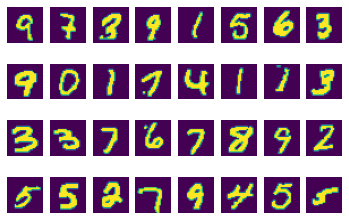


============The Reconstruct Images=============


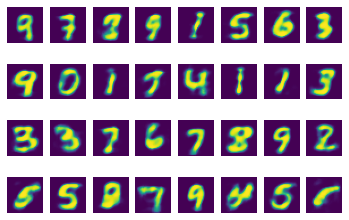

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(sample_data,col_num=4,row_num=8,count=0):
    for i in sample_data:
        plt.subplot(col_num,row_num,count+1)
        plt.imshow(np.squeeze(i.asnumpy()))
        plt.axis("off")
        count += 1
    plt.show()

sample = next(ds_train.create_dict_iterator(output_numpy=True, num_epochs=1))
sample_x = Tensor(sample['image'], dtype=mstype.float32)
sample_y = Tensor(sample['label'], dtype=mstype.int32)
reconstructed_sample = cvae.reconstruct_sample(sample_x, sample_y)
print('The shape of the reconstructed sample is ', reconstructed_sample.shape)
print("\n=============The Original Images=============")
plot_image(sample_x)
print("\n============The Reconstruct Images=============")
plot_image(reconstructed_sample)

对比原图片，CVAE生成的图片能明显对应上原始图片，但还稍显模糊。说明训练效果已经达到但还有提升空间。

### 条件样本采样

在隐空间中进行条件采样，本例使用条件为`(0,1)`，对应生成`(0,1)`的图像数据，同时将采样生成的数据进行可视化。

The shape of the generated sample is  (32, 1, 32, 32)


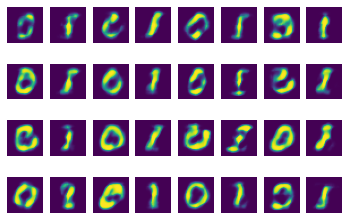

In [7]:
# test function: generate_sample
sample_label = Tensor([i for i in range(0,2)]*16, dtype=mstype.int32)
# test function: generate_sample
generated_sample = cvae.generate_sample(sample_label, 32, IMAGE_SHAPE)
# test function: reconstruct_sample
print('The shape of the generated sample is ', generated_sample.shape)
plot_image(generated_sample,4,8)

在条件为`(0,1)`特征采样中，生成的图片有的看起来像其他的数字，说明图像在特征分布中，其他数字的部分特征与`(0,1)`的特征出现了交叉，而随机采样正好采样到了这些交叉特征，导致`(0,1)`图片出现了其他数字的特征。